Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [41]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy


## The *Nim* and *Nimply* classes

In [42]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [43]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [44]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [45]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


INFO:root:Best solution: (True, -3) (with σ=1.78 from actor Agent 47)
INFO:root:Weights: [  5.62381551   5.36278926   0.9887851   13.26840519  -2.36568517
  17.40400211  -0.46190432  23.20198028   9.39784918 -24.83438562
   1.53112808  16.35879062  14.98054736 -11.15776865  37.46859994
   0.87503119  -9.4210111  -14.44042946 -23.16316597   3.74836263
  10.5209502   -7.05338526] (with σ=1.78)


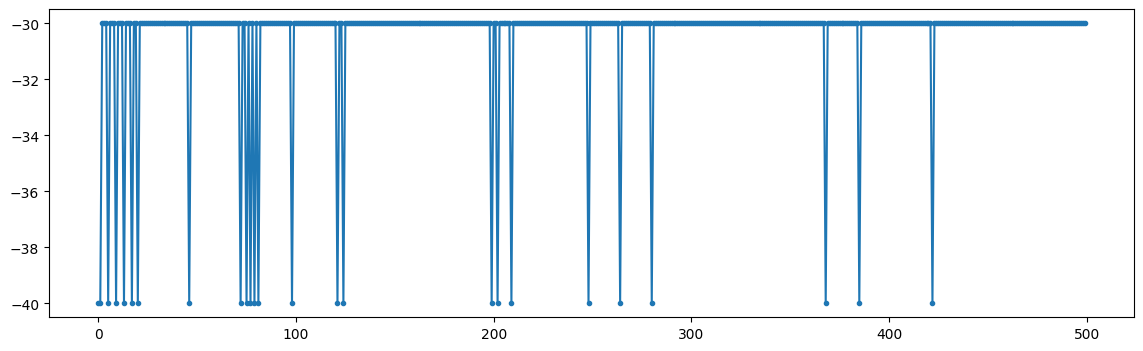

In [5]:
from nim import Nim,Nimply,play_game
from pop_funct import select_parents,mutate,fitness
from nim_agents import pure_random,gabriele,optimal,AgentsVec,NimAgent
import random
import numpy as np
import logging
from matplotlib import pyplot as plt
from matplotlib import cm
from copy import deepcopy
import rules as rs


def main():
    λ = 200
    σ = 0.001
    μ = 50 
    STEPS = 100_000
    # Specifica la lista di regole.

    tr_rules = [
            rs.rule_is_even,
            rs.rule_is_odd,
            rs.rule_is_multiple_of_3_and_5,
            rs.rule_is_perfect_square,
            rs.rule_is_prime,
            rs.rule_is_multiple_of_golden_ratio
        ]

    tr_weights = [-158.37343213 ,-177.89434133,   15.06265569   ,83.63611385  ,-87.40610713,
   49.67343213] 

    # qui ancora devi mettere le regole. trovi un elenco su rules.py
    rules = [
        rs.rule_is_even,
        rs.rule_is_even_2,
        rs.rule_is_even_3,
        rs.rule_is_even_4,
        rs.rule_is_even_5,
        rs.rule_is_odd,
        rs.rule_is_odd_2,
        rs.rule_is_odd_3,
        rs.rule_is_odd_4,
        rs.rule_is_odd_5,
        rs.rule_is_perfect_square,
        rs.rule_is_perfect_square_2,
        rs.rule_is_perfect_square_3,
        rs.rule_is_perfect_square_4,
        rs.rule_is_perfect_square_5,
        rs.rule_is_prime,
        rs.rule_is_prime_2,
        rs.rule_is_prime_3,
        rs.rule_is_prime_4,
        rs.rule_is_prime_5,
        rs.rule_is_multiple_of_3_and_5,
        rs.rule_is_multiple_of_golden_ratio
    ]


    # Inizializza la popolazione di agenti con pesi casauli per ogni regola
    population = np.array([
        NimAgent(f"Agent {i}",np.array(rules), np.random.random(len(rules)),σ)
        for i in range(μ)
    ])


    player2 =  NimAgent(f"Agent 1",np.array(tr_rules), tr_weights,σ)
    agents = AgentsVec([optimal])
    opposer = agents.first()

    best_fitness = None
    history = list()

    # Esegui l'algoritmo evolutivo per 1_000_000 // λ generazioni.
    for step in range(STEPS // λ):
        fit_vec = []

        #after each 1/3 of the 
        if step % ((STEPS // λ) // 3) == 0:
            opposer = agents.next()

        # Seleziona gli agenti a caso e creane una copia (figli)
        offspring = select_parents(population,μ,λ)

        # Applica la mutazione agli agenti copiati.
        mutate(offspring)
        # print(f"Offspring dopo mutate: {offspring}")

        for player in offspring:
            #make the order of player randomic
            my_strategy = player.choose_move
            strategy = [my_strategy,opposer]
            random.shuffle(strategy)
            index = strategy.index(my_strategy)      #take the index of our ES actor
            strategy = tuple(strategy)

            #from the match return some parameters as result
            params = play_game(strategy)
            fit = fitness(index,params)
            #save the fitness inside the player class
            player.setFitness(fit)
            #and in a fitness vector
            fit_vec.append(fit)

        #order the offspring vector according to their fitness value    
        #print(f"Fit vec: {fit_vec}")
        
        fit_vec_np = np.array(fit_vec, dtype=[('bool', bool), ('num', int)])
        indices = np.argsort(fit_vec_np, order=['bool', 'num'])

        offspring = offspring[indices]

            # save best (just for the plot)
        if best_fitness is None or best_fitness < max(fit_vec):
            best_fitness = max(fit_vec)
            
        if max(fit_vec)[0] == True:
            fitness_hi = max(fit_vec)[1] * 10
        else:
            fitness_hi = max(fit_vec)[1] 
        
        history.append((step, fitness_hi))   

        population = deepcopy(offspring[-μ:])

        #print(f"Agente con il fitness più alto: {population[-1].getName()}")

    logging.info(
        f"Best solution: {population[-1].getFitness()} (with σ={population[-1].σ:0.3g} from actor {population[-1].getName()})"
    )

    logging.info(
        f"Weights: {population[-1].weights} (with σ={population[-1].σ:0.3g})"
    )

    history = np.array(history)
    plt.figure(figsize=(14, 4))
    plt.plot(history[:, 0], history[:, 1], marker=".")
    return history

if __name__ == "__main__":
  history = main()

In [6]:
history


array([[  0, -40],
       [  1, -40],
       [  2, -30],
       [  3, -30],
       [  4, -30],
       [  5, -40],
       [  6, -30],
       [  7, -30],
       [  8, -30],
       [  9, -40],
       [ 10, -30],
       [ 11, -30],
       [ 12, -30],
       [ 13, -40],
       [ 14, -30],
       [ 15, -30],
       [ 16, -30],
       [ 17, -40],
       [ 18, -30],
       [ 19, -30],
       [ 20, -40],
       [ 21, -30],
       [ 22, -30],
       [ 23, -30],
       [ 24, -30],
       [ 25, -30],
       [ 26, -30],
       [ 27, -30],
       [ 28, -30],
       [ 29, -30],
       [ 30, -30],
       [ 31, -30],
       [ 32, -30],
       [ 33, -30],
       [ 34, -30],
       [ 35, -30],
       [ 36, -30],
       [ 37, -30],
       [ 38, -30],
       [ 39, -30],
       [ 40, -30],
       [ 41, -30],
       [ 42, -30],
       [ 43, -30],
       [ 44, -30],
       [ 45, -30],
       [ 46, -40],
       [ 47, -30],
       [ 48, -30],
       [ 49, -30],
       [ 50, -30],
       [ 51, -30],
       [ 52,

In [47]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [48]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=6)
INFO:root:status: <1 3 5 1 9>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 1 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 3 5 1 8>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 3 5 0 8>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=5)
INFO:root:status: <0 3 0 0 8>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=7)
INFO:root:status: <0 3 0 0 1>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 3 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 2 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 1 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!
